In [ ]:
folder_path = 'raw_data/kana_colourpreferencequalia-master/data'
response_type = 'similarity'

In [ ]:
import os
import pickle as pkl
import sys
sys.path.append('/Users/kana/Library/Mobile Documents/com~apple~CloudDocs/Codes/GWOT_colorprefrencequalia')
import numpy as np
import pandas as pd
import sklearn
import csv
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import MDS
import seaborn as sns
import ot
import plotly.graph_objs as go
import plotly.express as px
from mpl_toolkits.axes_grid1 import make_axes_locatable
import utilityFunctions
print(sys.path)
from itertools import combinations
import math

In [ ]:
def filter_practice_trials(df):
    """
    Filters out rows where the 'practice_trial' column has a value of 1.

    Args:
    - df (DataFrame): The input dataframe containing a 'practice_trial' column.

    Returns:
    - DataFrame: A filtered dataframe with rows where 'practice_trial' is not 1.
    """
    return df[df['practice_trial'] != 1]

def filter_response_type(df, response_type):
    """
    Filters the dataframe to include only rows with a specific response type.

    Args:
    - df (DataFrame): The input dataframe containing a 'response_type' column.
    - response_type (str): The specific response type to filter by.

    Returns:
    - DataFrame: A filtered dataframe containing only rows where 'response_type' matches the specified value.
    """
    return df[df['response_type'] == response_type]

def extract_first_trial_indices(df, num_trials):
    """
    Extracts the first N trial indices from the dataframe.

    Args:
    - df (DataFrame): The input dataframe containing a 'trials.thisIndex' column.
    - num_trials (int): The number of trial indices to extract.

    Returns:
    - List: A list of the first N trial indices.
    """
    return df['trials.thisIndex'].iloc[:num_trials].tolist()

def transform_indices(df, trial_indices):
    """
    Maps the given trial indices to a sequential range and adds a new column, 'transformed_index'.

    Args:
    - df (DataFrame): The input dataframe containing a 'trials.thisIndex' column.
    - trial_indices (List): A list of trial indices to map to a sequential range.

    Returns:
    - DataFrame: A filtered dataframe with an added 'transformed_index' column where the indices are sequentially mapped.
    """
    filtered_df = df[df['trials.thisIndex'].isin(trial_indices)]
    unique_indices = list(filtered_df['trials.thisIndex'].unique())
    index_mapping = {original: new for new, original in enumerate(unique_indices, start=1)}
    filtered_df['transformed_index'] = filtered_df['trials.thisIndex'].map(index_mapping)
    return filtered_df


def calculate_response_correlation(filtered_df):
    """
    Calculates response pairs and their correlation.

    Args:
    - filtered_df (DataFrame): The filtered dataframe grouped by 'transformed_index'
                               and containing a 'response' column.

    Returns:
    - float: The correlation value between the first and second responses in the response pairs.
             Returns None if no valid response pairs exist.
    """
    grouped = filtered_df.groupby('transformed_index')
    response_pairs = []

    for transformed_index, group in grouped:
        y = group['response'].tolist()

        if len(y) == 2:  # Only consider pairs of responses
            response_pairs.append(y)

    # Calculate correlation
    if response_pairs:
        first_responses = [pair[0] for pair in response_pairs]
        second_responses = [pair[1] for pair in response_pairs]
        correlation = pd.Series(first_responses).corr(pd.Series(second_responses))
    else:
        correlation = None

    return correlation

def plot_scatter_with_connections_and_correlation(ax, filtered_df, pair_correlation, custom_title_prefix):
    """
    Plots scatter points and connections for the first and second halves of the data,
    and displays the plot with the provided correlation value in the title.

    Args:
    - ax: axes to plot on (from plt.gca() or  plt.sca())
    - filtered_df (DataFrame): A filtered dataframe with 'transformed_index' and 'response' columns.
    - pair_correlation (float): The pre-computed correlation value to display in the plot title.
    - custom_title_prefix (str): A custom string to include as a prefix in the plot title.

    Returns:
    - None: The function generates a plot and displays it.
    """
    #plt.figure(figsize=(10, 6))

    # Split the dataframe into two halves
    midpoint = len(filtered_df) // 2
    first_half = filtered_df.iloc[:midpoint]
    second_half = filtered_df.iloc[midpoint:]

    # Plot scatter points and draw a line for the first half
    if not first_half.empty:
        ax.scatter(first_half['transformed_index'], first_half['response'], color='blue', s=50, label='First Half')
        ax.plot(first_half['transformed_index'], first_half['response'], color='blue', linewidth=1.5, label='First Half Line')

    # Plot scatter points and draw a line for the second half
    if not second_half.empty:
        ax.scatter(second_half['transformed_index'], second_half['response'], color='green', s=50, label='Second Half')
        ax.plot(second_half['transformed_index'], second_half['response'], color='green', linewidth=1.5, label='Second Half Line')

    # Add labels and title with correlation
    ax.set_xlabel('trial') # "transformed index" as the trial number
    ax.set_ylabel('response')
    title_text = f"P{custom_title_prefix} Double pass r: {pair_correlation:.2f}" if pair_correlation is not None else f"{custom_title_prefix} Double pass r: N/A"
    ax.set_title(title_text)
    ax.legend()

In [ ]:
# Main function to process a single CSV file
def process_csv(file_path, response_type):
    df = utilityFunctions.load_csv(file_path)
    df = filter_practice_trials(df)
    df = filter_response_type(df, response_type)
    first_25_indices = extract_first_trial_indices(df, num_trials=25)
    filtered_df = transform_indices(df, first_25_indices)
    pair_correlation = calculate_response_correlation(filtered_df)
    #plot_scatter_with_connections_and_correlation(filtered_df, pair_correlation, custom_title_prefix)

    return filtered_df, pair_correlation

C:\Users\this_\AppData\Local\Temp\ipykernel_33040\2429637415.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['transformed_index'] = filtered_df['trials.thisIndex'].map(index_mapping)
C:\Users\this_\AppData\Local\Temp\ipykernel_33040\2429637415.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['transformed_index'] = filtered_df['trials.thisIndex'].map(index_mapping)
C:\Users\this_\AppData\Local\Temp\ipykernel_33040\2429637415.py:53: SettingWithCopyWarning: 
A value is trying t

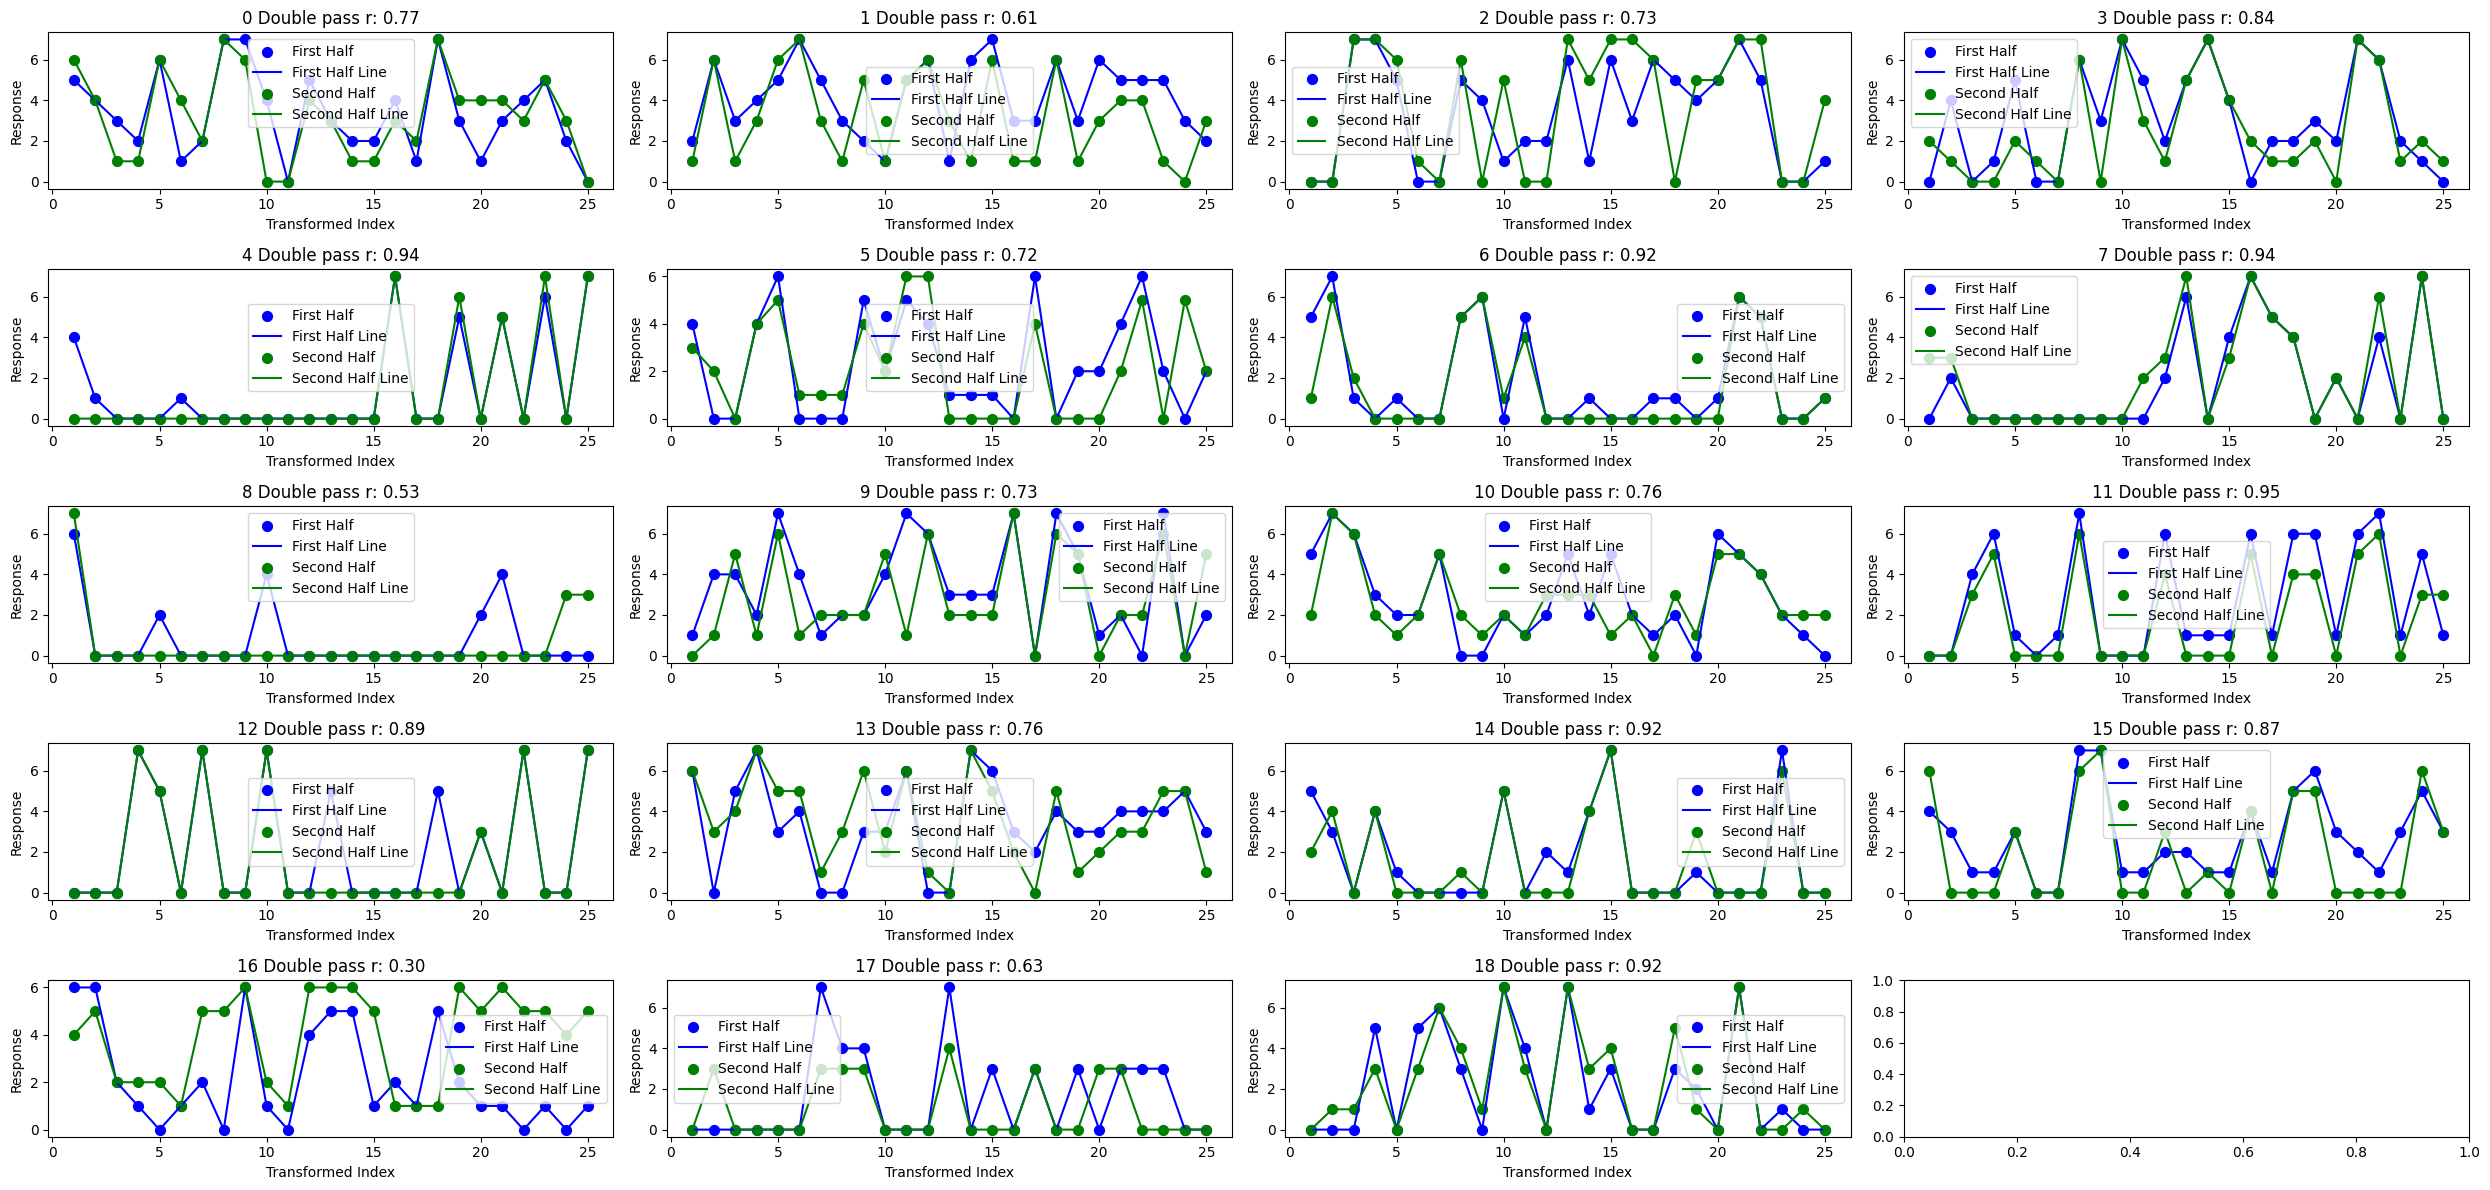

In [43]:
## Process all CSV files in the specified folder
sorted_files = utilityFunctions.sort_files_in_directory(folder_path)

filtered_dfs = []
pair_correlations = []
for index, filename in enumerate(sorted_files, start=0):
    if filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)
        
        # Assign a numerical string as the custom title prefix
        #custom_title_prefix = str(index)
        
        # Process the file
        filtered_df, pair_correlation = process_csv(file_path, response_type)
        filtered_dfs.append(filtered_df)
        pair_correlations.append(pair_correlation)


## Plot double passes for each participant

# Determine number of subplot panels (number of rows = number of columns)
num_plots = len(pair_correlations)
grid_size = math.ceil(math.sqrt(num_plots))  # Determine the grid size
#fig, axs = plt.subplots(grid_size, grid_size, figsize=(5 * grid_size, 5 * grid_size))

# OR manually set subplot dimensions
fig, axs = plt.subplots(5, 4, figsize=(5*5, 3*4))

# axs is a 2D, so flatten in order to plt.sca with just one index
if isinstance(axs, np.ndarray):
    axs = axs.flatten()
else:
    axs = [axs]  # Ensure axs is iterable if there's only one panel

for p in range(0, len(pair_correlations)):
    ax = axs[p]

    #plt.sca(ax)
    
    plot_scatter_with_connections_and_correlation(ax, filtered_dfs[p], pair_correlations[p], str(p))

plt.tight_layout()
plt.show()